In [1]:
# basic
import numpy as np
import pandas as pd

# diagnostics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# models
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# cosmetics
import warnings
warnings.filterwarnings('ignore')

# Part 1. Data Preparation

## Read Data

In [2]:
data = pd.read_csv('hw2_data.csv')
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data['date'] = pd.to_datetime(data['date'])
# drop ask and bid features as they are less useful for monthly data
data = data.drop(columns=['ask', 'bid'])

## Data Imputation

In [3]:
def get_na_in_data(data):
    na_col = data.isna().sum()
    na_col = na_col[na_col > 0]
    na_col_names = na_col.index.to_list()
    if na_col.empty:
        print("No more NA in data")
    else:
        print(na_col)
    return na_col_names

na_col_names = get_na_in_data(data)

ticker           252
log_size           4
log_bm           154
log_pcf       185970
mom            38869
vol           249632
roa            15221
roe            18634
log_to         38960
ols_3m_d      369581
ols_1y_d      369581
ols_5y_m      369581
f_ols_1y_d    369581
dtype: int64


### Imputation Step 1. ffill ticker

In [4]:
def fill_ticker(group):
    group['ticker'] = group['ticker'].fillna(method='ffill')
    return group
    
data = data.sort_values(by='date').groupby('ticker').apply(fill_ticker)
data.reset_index(drop=True, inplace=True)
na_col_names = get_na_in_data(data)

log_size           4
log_bm           154
log_pcf       185941
mom            38844
vol           249473
roa            15221
roe            18622
log_to         38775
ols_3m_d      369427
ols_1y_d      369427
ols_5y_m      369427
f_ols_1y_d    369427
dtype: int64


### Imputation Step 2. drop NA target variable (f_ols_1y_d)

In [5]:
data.dropna(inplace=True, subset=['f_ols_1y_d'])
na_col_names = get_na_in_data(data)

log_bm         39
log_pcf    114159
mom           132
vol          9011
roa          6732
roe          5323
log_to      18378
dtype: int64


### Imputation Step 3. deal with NA features

In [6]:
# use historical mean for each ticker to fill remaining NA
def fill_na_with_historical_mean(group):
    for col in na_col_names:
        historical_mean = group[col].expanding(min_periods=1).mean()
        group[col] = group[col].fillna(historical_mean)
    return group
    
data = data.sort_values(by='date').groupby('ticker').apply(fill_na_with_historical_mean)
data.reset_index(drop=True, inplace=True)
na_col_names = get_na_in_data(data)

log_pcf    22523
mom           12
vol         7397
roa         3536
roe         1266
log_to     15746
dtype: int64


In [7]:
# drop the remaining NA features until first valid for each ticker.
def drop_until_first_valid_and_ffill(group):
    group = group.dropna(subset=na_col_names, how='any')
    return group

data = data.sort_values(by='date').groupby('ticker').apply(drop_until_first_valid_and_ffill)
data.reset_index(drop=True, inplace=True)
na_col_names = get_na_in_data(data)
data.to_csv("data/cleaned_data.csv", index=False)

No more NA in data


## Feature Selection

From correlation plots and the Paper, the following features are selected:
- log_size
- log_pcf
- log_to
- vol
- ols_3m_d
- ols_1y_d
- ols_5y_m

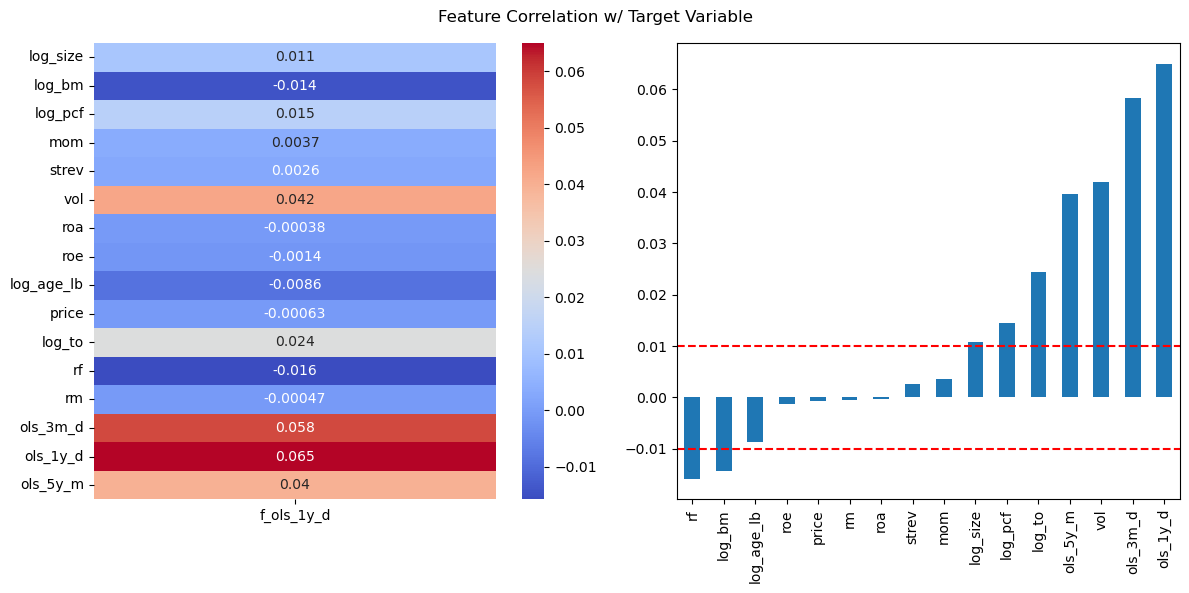

In [8]:
numeric_columns = ['log_size', 'log_bm', 'log_pcf', 'mom', 'strev', 'vol', 'roa', 'roe', 'log_age_lb', 
                   'price', 'log_to', 'rf', 'rm', 'ols_3m_d', 'ols_1y_d', 'ols_5y_m', 'f_ols_1y_d']
data_num = data[numeric_columns]
correlations = data_num.corr()[['f_ols_1y_d']]
correlations = correlations.drop(['f_ols_1y_d'], axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.heatmap(correlations, ax=axes[0], annot=True, cmap='coolwarm')
correlations.sort_values(by='f_ols_1y_d').plot(kind='bar',ax=axes[1], legend=False)
axes[1].axhline(y=0.01, color='red', linestyle='--')
axes[1].axhline(y=-0.01, color='red', linestyle='--')
plt.suptitle("Feature Correlation w/ Target Variable")
plt.tight_layout()  # Adjusts subplot params for a nicer layout
plt.show()

selected_features = ['log_size', 'log_pcf', 'log_to', 'vol', 'ols_3m_d', 'ols_1y_d', 'ols_5y_m']

## Data Engineering & Data Split

In [9]:
y = data['f_ols_1y_d']
X = data[selected_features]
for col in X.columns:
    col_mean = X[col].mean()
    col_std = X[col].std()
    X[col] = (X[col] - col_mean) / col_std
    X[col] = X[col].clip(lower=-3, upper=3) # normalize features to [-3,3]

# Split train, val, test
test_time_start = data['date'].max() - pd.DateOffset(years=5) # last 5 years as test
val_time_start = test_time_start - pd.DateOffset(years=2) # last 2 years as val
data_test = data[data['date'] >= test_time_start]
data_val = data[(data['date'] >= val_time_start) & (data['date'] < test_time_start)]
data_train = data[data['date'] < val_time_start]
X_test = X[data['date'] >= test_time_start]
X_val = X[(data['date'] >= val_time_start) & (data['date'] < test_time_start)]
X_train = X[data['date'] < val_time_start]
y_test = y[data['date'] >= test_time_start]
y_val = y[(data['date'] >= val_time_start) & (data['date'] < test_time_start)]
y_train = y[data['date'] < val_time_start]

# special train set for time-series cross validation (automanaged by sklearn)
X = X[data['date'] < test_time_start]
y = y[data['date'] < test_time_start]

# Part 2. Run Models

In [10]:
### Helper Functions

# custom MAPE function because true beta is very small 
# (using sklearn will lead to arbitrarily large number)
def calc_MAPE(y_true, y_pred) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0 # handle the case where y_true is 0
    y_true, y_pred = y_true[mask], y_pred[mask]
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

def validation_helper(y_true: pd.Series, y_vals: list):
    result = pd.DataFrame(index=['MSE', 'MAPE'])
    for i in range(len(y_vals)):
        mse = mean_squared_error(y_true, y_vals[i])
        mape = calc_MAPE(y_true, y_vals[i])
        result[f'submodel_{i+1}'] = pd.Series([mse, mape], index=result.index)
    print(f"{result.loc['MSE'].idxmin()} has lowest MSE.")
    print(f"{result.loc['MAPE'].idxmin()} has lowest MAPE.")
    return result

## CAPM (baseline)

In [11]:
forecast_errors = pd.DataFrame(
    columns=['CAPM', 'OLS', 'RF', 'XGB', 'LSTM', 'CNN'],
    index=['MSE', 'MAPE', 'diff_MSE', 'diff_MAPE']
)

# CAPM
forecast_errors['CAPM']['MSE'] = mean_squared_error(data_test['f_ols_1y_d'], data_test['ols_5y_m'])
forecast_errors['CAPM']['MAPE'] = calc_MAPE(data_test['f_ols_1y_d'], data_test['ols_5y_m'])
forecast_errors

,CAPM,OLS,RF,XGB,LSTM,CNN
MSE,0.302756,NaN,NaN,NaN,NaN,NaN
MAPE,2.148366,NaN,NaN,NaN,NaN,NaN
diff_MSE,NaN,NaN,NaN,NaN,NaN,NaN
diff_MAPE,NaN,NaN,NaN,NaN,NaN,NaN


## OLS

In [12]:
%%time
# train
model_OLS = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model_OLS_reg_l1 = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Gaussian()).fit_regularized(L1_wt=1, alpha=0.1)
model_OLS_reg_l2 = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Gaussian()).fit_regularized(L1_wt=0, alpha=0.1)

# val
y_hat_val_OLS = model_OLS.predict(sm.add_constant(X_val))
y_hat_val_OLS_reg_l1 = model_OLS_reg_l1.predict(sm.add_constant(X_val))
y_hat_val_OLS_reg_l2 = model_OLS_reg_l2.predict(sm.add_constant(X_val))
validation_helper(y_val, [y_hat_val_OLS, y_hat_val_OLS_reg_l1, y_hat_val_OLS_reg_l2])

submodel_1 has lowest MSE.
submodel_3 has lowest MAPE.
CPU times: total: 5.98 s
Wall time: 15.2 s


,submodel_1,submodel_2,submodel_3
MSE,0.212647,0.310399,1.188700
MAPE,1.258783,1.221906,0.953021


In [13]:
# test using OLS (no reg)
y_hat = model_OLS.predict(sm.add_constant(X_test))
forecast_errors['OLS']['MSE'] = mean_squared_error(y_test, y_hat)
forecast_errors['OLS']['MAPE'] = calc_MAPE(y_test, y_hat)
forecast_errors.iloc[2:,1] = forecast_errors.iloc[0:2, 1] - forecast_errors.iloc[0:2, 0]
forecast_errors

,CAPM,OLS,RF,XGB,LSTM,CNN
MSE,0.302756,0.276213,NaN,NaN,NaN,NaN
MAPE,2.148366,1.814383,NaN,NaN,NaN,NaN
diff_MSE,NaN,-0.026543,NaN,NaN,NaN,NaN
diff_MAPE,NaN,-0.333982,NaN,NaN,NaN,NaN


In [14]:
model_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             f_ols_1y_d   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     418.8
Date:                Wed, 07 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:34:00   Log-Likelihood:            -2.2173e+06
No. Observations:              699582   AIC:                         4.435e+06
Df Residuals:                  699574   BIC:                         4.435e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9368      0.007    132.813      0.000       0.923       0.951
log_size      -0.0296      0.021     -1.385      0.166      -0.071       0.012
log_pcf        0.0046      0.007      0.637      0.524      -0.010       0.019
log_to         0.0882      0.021      4.160      0.000       0.047       0.130
vol            0.0685      0.010      6.824      0.000       0.049       0.088
ols_3m_d       0.0976      0.012      8.472      0.000       0.075       0.120
ols_1y_d       0.2046      0.013     16.310      0.000       0.180       0.229
ols_5y_m       0.0432      0.008      5.222      0.000       0.027       0.059
================================================================================
Omnibus:                  4790294.030   Durbin-Watson:                     1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   8882462073186563.000
Skew:                         715.448   Prob(JB):                           0.00
Kurtosis:                  552018.827   Cond. No.                           7.04
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## RF

In [15]:
# %%time
# model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     booster='gbtree',
#     subsample=0.8,  # Subsample ratio of the training instances
#     colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
#     random_state=5
# )

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 6, 10]
# }

# tscv = TimeSeriesSplit(n_splits=5)
# grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=3)
# grid_search.fit(X, y)
# print(f"Best parameters: {grid_search.best_params_}")
# best_model = grid_search.best_estimator_
# best_model.save_model('models/RF.json')

In [16]:
best_model = xgb.XGBRegressor()
best_model.load_model('models/RF.json')
y_pred = best_model.predict(X_test)
forecast_errors['RF']['MSE'] = mean_squared_error(y_test, y_pred)
forecast_errors['RF']['MAPE'] = calc_MAPE(y_test, y_pred)
forecast_errors.iloc[2:,2] = forecast_errors.iloc[0:2, 2] - forecast_errors.iloc[0:2, 0]
forecast_errors

,CAPM,OLS,RF,XGB,LSTM,CNN
MSE,0.302756,0.276213,0.479501,NaN,NaN,NaN
MAPE,2.148366,1.814383,1.825398,NaN,NaN,NaN
diff_MSE,NaN,-0.026543,0.176745,NaN,NaN,NaN
diff_MAPE,NaN,-0.333982,-0.322968,NaN,NaN,NaN


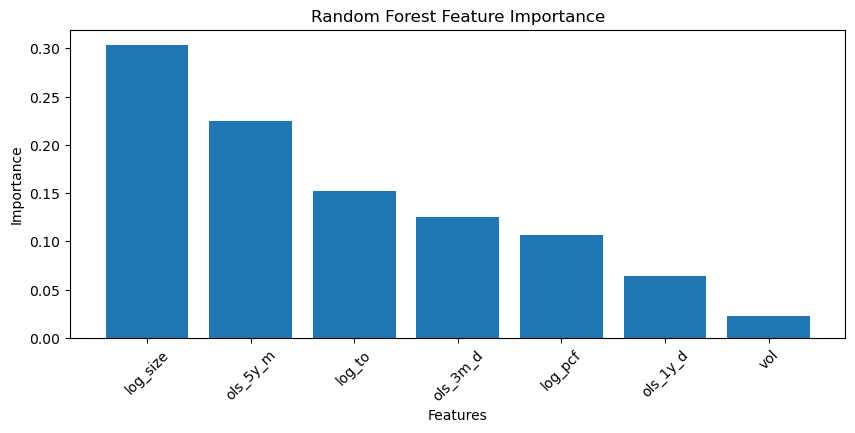

In [17]:
feature_importances_rf = best_model.feature_importances_

# Sort the feature importances in descending order and plot
sorted_idx_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(10, 4))
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_idx_rf])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(range(X.shape[1]), np.array(X.columns)[sorted_idx_rf], rotation=45)
plt.show()

## XGB

In [18]:
# %%time
# model = xgb.XGBRegressor(
#     objective='reg:squarederror',  # Objective function for regression
#     random_state=42               # Random seed for reproducibility
# )

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.1, 0.2],
#     'gamma': [0.0, 0.1, 0.2, 1.0],
# }

# tscv = TimeSeriesSplit(n_splits=5)
# grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=3)
# grid_search.fit(X, y)
# print(f"Best parameters: {grid_search.best_params_}")
# best_model = grid_search.best_estimator_
# best_model.save_model('models/XGB.json')

In [28]:
best_model = xgb.XGBRegressor()
best_model.load_model('models/XGB.json')
y_pred = best_model.predict(X_test)
forecast_errors['XGB']['MSE'] = mean_squared_error(y_test, y_pred)
forecast_errors['XGB']['MAPE'] = calc_MAPE(y_test, y_pred)
forecast_errors.iloc[2:,3] = forecast_errors.iloc[0:2, 3] - forecast_errors.iloc[0:2, 0]
forecast_errors

,CAPM,OLS,RF,XGB,LSTM,CNN
MSE,0.302756,0.276213,0.479501,0.370984,0.334081,0.339727
MAPE,2.148366,1.814383,1.825398,1.663747,1.947964,1.907476
diff_MSE,NaN,-0.026543,0.176745,0.068229,0.031326,0.036971
diff_MAPE,NaN,-0.333982,-0.322968,-0.484619,-0.200402,-0.24089


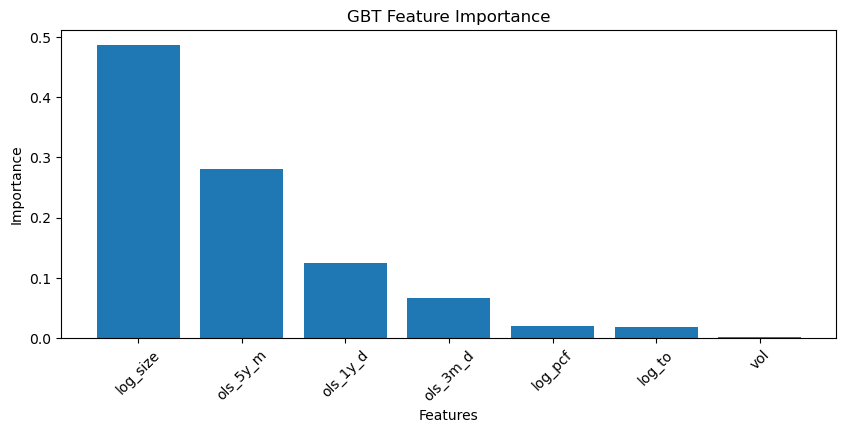

In [29]:
feature_importances_rf = best_model.feature_importances_

# Sort the feature importances in descending order and plot
sorted_idx_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(10, 4))
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_idx_rf])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('GBT Feature Importance')
plt.xticks(range(X.shape[1]), np.array(X.columns)[sorted_idx_rf], rotation=45)
plt.show()

## LSTM

In [21]:
### Data Specific to PyTorch
batch_size = 64

# read the tensor data prepared by another notebook
X_tensor_train = torch.load('data/X_train.pt')
X_tensor_val = torch.load('data/X_val.pt')
X_tensor_test = torch.load('data/X_test.pt')
y_tensor_train = torch.load('data/y_train.pt')
y_tensor_val = torch.load('data/y_val.pt')
y_tensor_test = torch.load('data/y_test.pt')

# convert to float32
X_tensor_train = X_tensor_train.float()
X_tensor_val = X_tensor_val.float()
X_tensor_test = X_tensor_test.float()
y_tensor_train = y_tensor_train.float()
y_tensor_val = y_tensor_val.float()
y_tensor_test = y_tensor_test.float()

# Create TensorDatasets
train_dataset = TensorDataset(X_tensor_train, y_tensor_train)
val_dataset = TensorDataset(X_tensor_val, y_tensor_val)
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# convert tensor back to numpy
y_tensor_val = y_tensor_val.detach().cpu().numpy()
y_tensor_test = y_tensor_test.detach().cpu().numpy()

In [22]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [23]:
# %%time
# ### Training & Hyperparameter Tuning
# num_epochs = 5
# param_grid = {
#     'hidden_size': [50, 100],
#     'num_layers': [1, 2],
#     'lr': [0.001, 0.01]  # Learning rate
# }

# # Function to train the model and return validation performance
# def train_evaluate(params):
#     model = CustomLSTM(input_size=7, hidden_size=params['hidden_size'], num_layers=params['num_layers'], output_size=1)
#     optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
#     criterion = nn.MSELoss()

#     if torch.cuda.is_available():
#         model.cuda()

#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0  # Initialize total training loss
#         for inputs, targets in train_loader:
#             if torch.cuda.is_available():
#                 inputs, targets = inputs.cuda(), targets.cuda()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             total_train_loss += loss.item() * inputs.size(0)
#         average_train_loss = total_train_loss / len(train_loader.dataset)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {average_train_loss:.4f}')

#     # Validation loop
#     model.eval()
#     total_val_loss = 0
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             if torch.cuda.is_available():
#                 inputs, targets = inputs.cuda(), targets.cuda()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             total_val_loss += loss.item() * inputs.size(0)

#     # Report
#     average_val_loss = total_val_loss / len(val_loader.dataset)
#     print(f'Validation Loss: {average_val_loss:.4f}')
#     return average_val_loss, model.state_dict()

# # Hyperparameter search
# best_score = float('inf')
# best_params = {}
# best_model_state = None  # To save the state of the best model
# for hidden_size in param_grid['hidden_size']:
#     for num_layers in param_grid['num_layers']:
#         for lr in param_grid['lr']:
#             params = {'hidden_size': hidden_size, 'num_layers': num_layers, 'lr': lr}
#             score, model_state = train_evaluate(params)  # Modify train_evaluate to return model state as well
#             if score < best_score:
#                 best_score = score
#                 best_params = params
#                 best_model_state = model_state
# print("Best Params LSTM:", best_params)

# # Load & save the best model
# best_model = CustomLSTM(
#     input_size=7, 
#     hidden_size=best_params['hidden_size'], 
#     num_layers=best_params['num_layers'], 
#     output_size=1
# )
# best_model.load_state_dict(best_model_state)
# torch.save(best_model, 'models/lstm.pth')

In [24]:
### Test
model = torch.load('models/lstm.pth')
if torch.cuda.is_available():
    model.cuda()
model.eval()
with torch.no_grad():
    if torch.cuda.is_available():
        X_tensor_test = X_tensor_test.cuda()
    y_pred = model(X_tensor_test)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = y_pred.reshape((y_pred.shape[0],))

forecast_errors['LSTM']['MSE'] = mean_squared_error(y_tensor_test, y_pred)
forecast_errors['LSTM']['MAPE'] = calc_MAPE(y_tensor_test, y_pred)
forecast_errors.iloc[2:,4] = forecast_errors.iloc[0:2, 4] - forecast_errors.iloc[0:2, 0]
forecast_errors

,CAPM,OLS,RF,XGB,LSTM,CNN
MSE,0.302756,0.276213,0.479501,0.370984,0.334081,NaN
MAPE,2.148366,1.814383,1.825398,1.663747,1.947964,NaN
diff_MSE,NaN,-0.026543,0.176745,0.068229,0.031326,NaN
diff_MAPE,NaN,-0.333982,-0.322968,-0.484619,-0.200402,NaN


## CNN

In [25]:
T, f = 12, len(selected_features)
class SimpleCNN(nn.Module):
    def __init__(self, num_features, num_output):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=f, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Adjust the size based on your input data
        self.fc = nn.Linear(in_features=32 * (T // 2 // 2), out_features=num_output)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to [batch_size, num_features, seq_len]
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten
        x = self.fc(x)
        return x

In [26]:
# %%time
# ### Training & Hyperparameter Tuning
# num_epochs = 5
# param_grid_cnn = {
#     'num_features': [7],  # Number of input features (depends on your data)
#     'num_output': [1],  # Output size
#     'lr': [0.001, 0.01]  # Learning rates to try
# }

# # Function to train and evaluate the CNN model
# def train_evaluate_cnn(params):
#     model = SimpleCNN(num_features=params['num_features'], num_output=params['num_output'])
#     optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
#     criterion = nn.MSELoss()

#     if torch.cuda.is_available():
#         model.cuda()

#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         for inputs, targets in train_loader:
#             if torch.cuda.is_available():
#                 inputs, targets = inputs.cuda(), targets.cuda()
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             total_train_loss += loss.item() * inputs.size(0)
#         average_train_loss = total_train_loss / len(train_loader.dataset)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {average_train_loss:.4f}')

#     # Validation loop
#     model.eval()
#     total_val_loss = 0
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             if torch.cuda.is_available():
#                 inputs, targets = inputs.cuda(), targets.cuda()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             total_val_loss += loss.item() * inputs.size(0)

#     # Report Result
#     average_val_loss = total_val_loss / len(val_loader.dataset)
#     print(f'Validation Loss: {average_val_loss:.4f}')
#     return average_val_loss, model.state_dict()

# # Hyperparameter search
# best_score_cnn = float('inf')
# best_params_cnn = {}
# best_model_state_cnn = None
# for num_features in param_grid_cnn['num_features']:
#     for num_output in param_grid_cnn['num_output']:
#         for lr in param_grid_cnn['lr']:
#             params = {'num_features': num_features, 'num_output': num_output, 'lr': lr}
#             score, model_state = train_evaluate_cnn(params)
#             if score < best_score_cnn:
#                 best_score_cnn = score
#                 best_params_cnn = params
#                 best_model_state_cnn = model_state
# print("Best Params CNN:", best_params_cnn)

# # Load & save the best CNN model
# best_model_cnn = SimpleCNN(
#     num_features=best_params_cnn['num_features'], 
#     num_output=best_params_cnn['num_output']
# )
# best_model_cnn.load_state_dict(best_model_state_cnn)
# torch.save(best_model_cnn, 'models/cnn.pth')

In [27]:
### Test
model = torch.load('models/cnn.pth')
if torch.cuda.is_available():
    model.cuda()
model.eval()
with torch.no_grad():
    if torch.cuda.is_available():
        X_tensor_test = X_tensor_test.cuda()
    y_pred = model(X_tensor_test)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = y_pred.reshape((y_pred.shape[0],))

forecast_errors['CNN']['MSE'] = mean_squared_error(y_tensor_test, y_pred)
forecast_errors['CNN']['MAPE'] = calc_MAPE(y_tensor_test, y_pred)
forecast_errors.iloc[2:,5] = forecast_errors.iloc[0:2, 5] - forecast_errors.iloc[0:2, 0]
forecast_errors

,CAPM,OLS,RF,XGB,LSTM,CNN
MSE,0.302756,0.276213,0.479501,0.370984,0.334081,0.339727
MAPE,2.148366,1.814383,1.825398,1.663747,1.947964,1.907476
diff_MSE,NaN,-0.026543,0.176745,0.068229,0.031326,0.036971
diff_MAPE,NaN,-0.333982,-0.322968,-0.484619,-0.200402,-0.24089
